In [1]:
%load_ext autoreload
%reload_ext autoreload 

In [2]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

In [4]:
print(f'Selected model: {model_display_name}')
print(f'Model Handle at TensorFlow Hub: {model_handle}')

Selected model: Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [5]:
# This will take 10 to 15 minutes to finish
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


In [6]:
# dictionary with image tags as keys, and image paths as values
TEST_IMAGES = {
  'Beach' : '/home/hasan/models/research/object_detection/test_images/image2.jpg',
  'Dogs' : '/home/hasan/models/research/object_detection/test_images/image1.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # By 663highland, Source: https://commons.wikimedia.org/wiki/File:Kitano_Street_Kobe01s5s4110.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg'
}

In [7]:
from preprocess_data import load_image_into_numpy_array

image height and ``numpy height width`` will interchange

In [8]:
image_path = TEST_IMAGES['Street']
image_np = load_image_into_numpy_array(image_path)

In [9]:
image_np.shape

(1, 1707, 2560, 3)

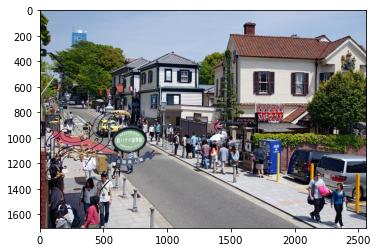

In [10]:
plt.figure()
plt.imshow(image_np[0])

In [11]:
# run inference
results = hub_model(image_np)


In [12]:
results

{'proposal_boxes': <tf.Tensor: shape=(1, 300, 4), dtype=float32, numpy=
 array([[[ 674.80164 ,  836.1527  ,  899.94556 , 1016.3247  ],
         [ 807.89294 ,  910.1315  , 1011.5403  ,  964.6322  ],
         [ 761.376   ,  830.9912  ,  993.9586  ,  898.9236  ],
         ...,
         [ 691.6802  ,  539.1567  ,  759.0359  ,  557.22797 ],
         [ 605.23584 ,   44.22346 , 1024.      ,  110.645996],
         [ 992.94135 ,  858.7665  , 1014.957   ,  891.1023  ]]],
       dtype=float32)>,
 'image_shape': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.000e+00, 1.024e+03, 1.024e+03, 3.000e+00], dtype=float32)>,
 'raw_detection_boxes': <tf.Tensor: shape=(1, 300, 4), dtype=float32, numpy=
 array([[[0.6592082 , 0.83994865, 0.8727151 , 0.99457145],
         [0.78706443, 0.890414  , 0.9958358 , 0.940042  ],
         [0.7492859 , 0.8159694 , 0.976108  , 0.8782268 ],
         ...,
         [0.6305717 , 0.52473193, 0.74491274, 0.54547614],
         [0.6268655 , 0.03596602, 0.98776567, 0.09741

In [13]:
result = {key:value.numpy() for key,value in results.items()}

# print the keys
for key in result.keys():
  print(key)

proposal_boxes
image_shape
raw_detection_boxes
class_predictions_with_background
detection_masks
rpn_box_encodings
detection_scores
refined_box_encodings
raw_detection_scores
num_detections
final_anchors
rpn_box_predictor_features
rpn_features_to_crop
num_proposals
rpn_objectness_predictions_with_background
anchors
mask_predictions
box_classifier_features
detection_classes
detection_multiclass_scores
proposal_boxes_normalized
detection_anchor_indices
detection_boxes


## Visualizing the results

You can now plot the results on the original image. First, you need to create the `category_index` dictionary that will contain the class IDs and names. The model was trained on the [COCO2017 dataset](https://cocodataset.org/) and the API package has the labels saved in a different format (i.e. `mscoco_label_map.pbtxt`). You can use the [create_category_index_from_labelmap](https://github.com/tensorflow/models/blob/5ee7a4627edcbbaaeb8a564d690b5f1bc498a0d7/research/object_detection/utils/label_map_util.py#L313) internal utility function to convert this to the required dictionary format.

In [14]:
PATH_TO_LABELS = '/home/hasan/models/research/object_detection/data/mscoco_label_map.pbtxt'

In [15]:
from object_detection.utils import label_map_util

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [17]:

# sample output
print(category_index[1])
print(category_index[2])
print(category_index[4])

{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 4, 'name': 'motorcycle'}


Next, you will preprocess the masks then finally plot the results.

* The result dictionary contains a `detection_masks` key containing segmentation masks for each box. That will be converted first to masks that will overlay to the full image size. 
* You will also select mask pixel values that are above a certain threshold. We picked a value of `0.6` but feel free to modify this and see what results you will get. If you pick something lower, then you'll most likely notice mask pixels that are outside the object.
* As you've seen before, you can use `visualize_boxes_and_labels_on_image_array()` to plot the results on the image. The difference this time is the parameter `instance_masks` and you will pass in the reframed detection boxes to see the segmentation masks on the image.

You can see how all these are handled in the code below.


In [18]:
from object_detection.utils import ops as utils_ops

In [21]:
from object_detection.utils import visualization_utils as viz_utils
import tensorflow as tf

<ipython-input-22-d2c6fe706367>:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


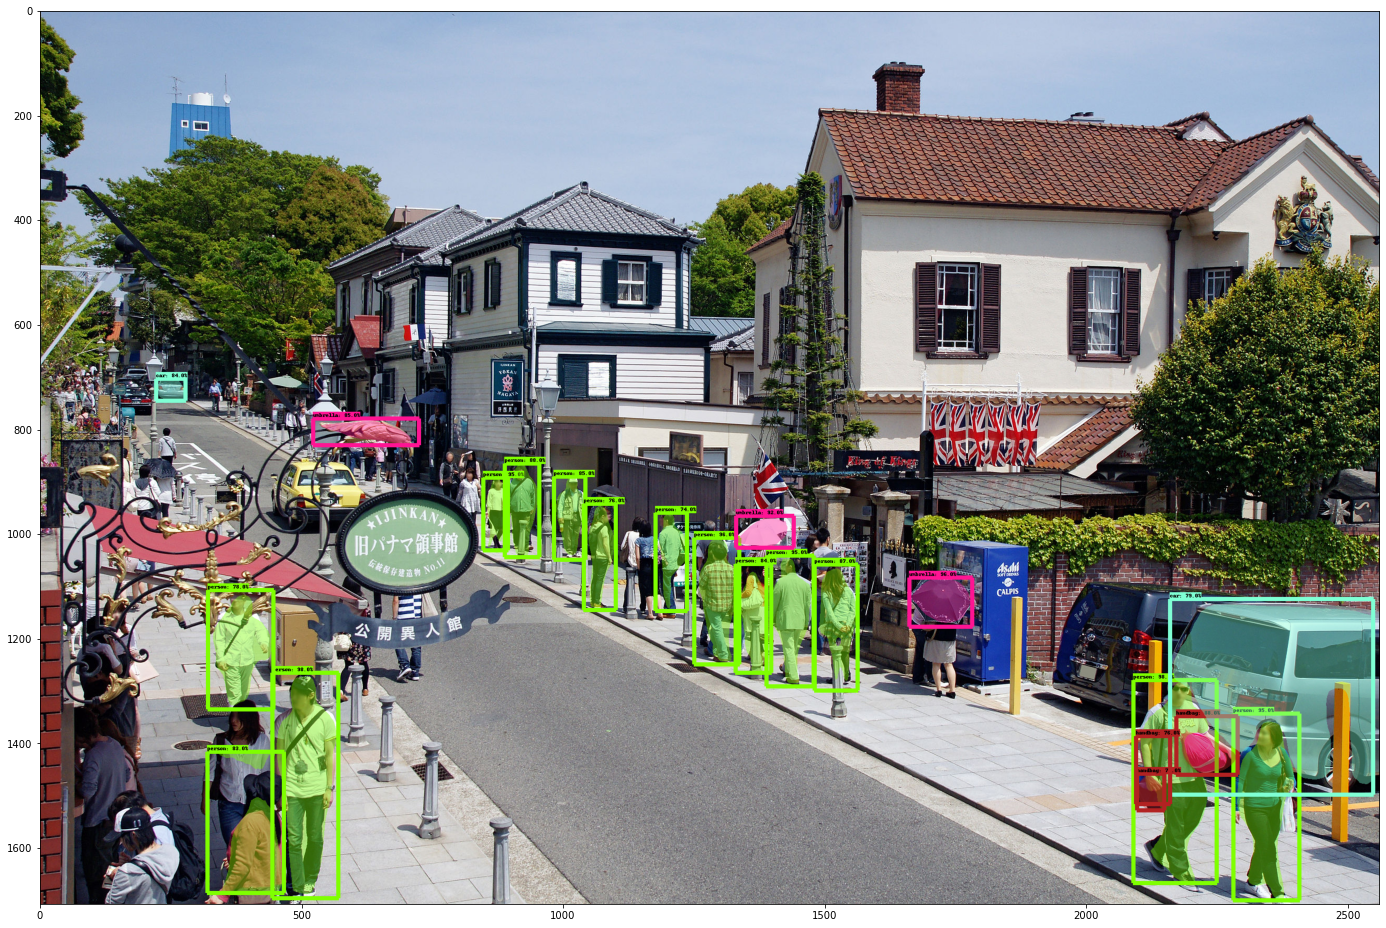

In [22]:
# Handle models with masks:
label_id_offset = 0
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:

  # convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # reframe the the bounding box mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])

  # filter mask pixel values that are above a specified threshold
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6,
                                      tf.uint8)
  
  # get the numpy array
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

# overlay labeled boxes and segmentation masks on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()